In [7]:
import tensorflow as tf
from tensorflow import keras
from keras import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [9]:
PATH = '/Users/divyamkumar/Desktop/OCT-8/data'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')
test_dir = os.path.join(PATH, 'test')

total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

print(total_test, total_val, total_train)

batch_size = 128
IMG_HEIGHT = 400
IMG_WIDTH = 400

200 16 17257


In [10]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
                    train_dir,
                    color_mode = "grayscale",
                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                    batch_size=batch_size,
                    class_mode='binary',
                    classes=['CNV', 'NORMAL'])
val_data_gen = validation_image_generator.flow_from_directory(
                    validation_dir,
                    color_mode = "grayscale",
                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                    batch_size=4,
                    class_mode='binary',
                    classes=['CNV', 'NORMAL'])
test_data_gen = test_image_generator.flow_from_directory(
                    PATH,
                    color_mode = "grayscale",
                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                    batch_size=20,
                    classes=['test'],
                    shuffle=False)

Found 17254 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Error processing line 3 of /Users/divyamkumar/Library/Python/3.9/lib/python/site-packages/googleapis_common_protos-1.61.0-py3.9-nspkg.pth:

  Traceback (most recent call last):
    File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/site.py", line 169, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 562, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored


Found 200 images belonging to 1 classes.


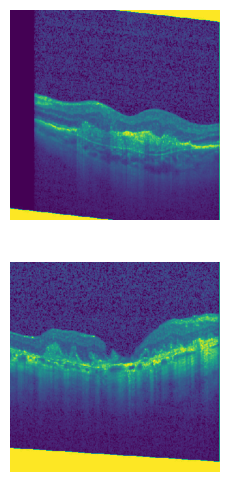

In [11]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:2])

Found 17254 images belonging to 2 classes.


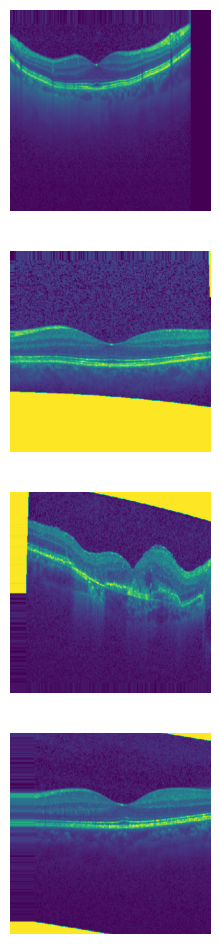

In [12]:
train_image_generator = ImageDataGenerator(
                        rescale=1./255,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=0.1
                        )

train_data_gen = train_image_generator.flow_from_directory(
                    train_dir,
                    color_mode = "grayscale",
                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                    batch_size=batch_size,
                    class_mode='binary',
                    classes=['CNV', 'NORMAL'])

augmented_images = [train_data_gen[0][0][i] for i in range(4)]

plotImages(augmented_images)

In [19]:
# def recall(y_true, y_pred):
#     y_true = keras.ones_like(y_true)
#     true_positives = keras.sum(keras.round(keras.clip(y_true * y_pred, 0, 1)))
#     all_positives = keras.sum(keras.round(keras.clip(y_true, 0, 1)))

#     recall = true_positives / (all_positives + keras.epsilon())
#     return recall

# def precision(y_true, y_pred):
#     y_true = keras.ones_like(y_true)
#     true_positives = keras.sum(keras.round(keras.clip(y_true * y_pred, 0, 1)))

#     predicted_positives = keras.sum(keras.round(keras.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + keras.epsilon())
#     return precision

# def f1_score(y_true, y_pred):
#     precision = precision(y_true, y_pred)
#     recall = recall(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+keras.epsilon()))


model = Sequential()
model.add(Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
model.add(Conv2D(16, (3,3), activation='relu',))
model.add(Conv2D(16, (3,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (3,3), activation='relu',))
model.add(Conv2D(16, (3,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 398, 398, 16)      160       
                                                                 
 conv2d_11 (Conv2D)          (None, 396, 396, 16)      2320      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 198, 198, 16)      0         
 ng2D)                                                           
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 99, 99, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 97, 97, 16)        2320      
                                                                 
 conv2d_13 (Conv2D)          (None, 95, 95, 16)       

In [20]:
history = model.fit(
            train_data_gen,
            steps_per_epoch=int(total_train/1024),
            validation_data=val_data_gen,
            validation_steps=int(total_val/4),
            epochs=10
            )

Epoch 1/10
16/16 [==============================] - 167s 10s/step - loss: 0.6886 - accuracy: 0.5366 - val_loss: 0.6914 - val_accuracy: 0.5000
Epoch 2/10
16/16 [==============================] - 187s 12s/step - loss: 0.6704 - accuracy: 0.5625 - val_loss: 0.6400 - val_accuracy: 0.5000
Epoch 3/10
16/16 [==============================] - 174s 11s/step - loss: 0.6282 - accuracy: 0.6245 - val_loss: 0.4644 - val_accuracy: 0.9375
Epoch 4/10
16/16 [==============================] - 112s 7s/step - loss: 0.5704 - accuracy: 0.6924 - val_loss: 0.3009 - val_accuracy: 1.0000
Epoch 5/10
16/16 [==============================] - 103s 6s/step - loss: 0.4917 - accuracy: 0.7744 - val_loss: 0.1491 - val_accuracy: 1.0000
Epoch 6/10
16/16 [==============================] - 100s 6s/step - loss: 0.4208 - accuracy: 0.8125 - val_loss: 0.0860 - val_accuracy: 1.0000
Epoch 7/10
16/16 [==============================] - 108s 7s/step - loss: 0.4009 - accuracy: 0.8159 - val_loss: 0.0683 - val_accuracy: 1.0000
Epoch 8/10

In [21]:
probabilities = model.predict(test_data_gen).flatten()

10/10 [==============================] - 2s 129ms/step


In [22]:
def check(probabilities):
  answers =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
              1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
              1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
              1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
              1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
              1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
              1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
              1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
              1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
              1, 1, 1, 1, 1, 1
              ]

  correct = 0

  for probability, answer in zip(probabilities, answers):
    if round(probability) == answer:
      correct +=1

  percentage_identified = (correct / len(answers)) * 100


  print(f"Your model correctly identified {round(percentage_identified, 3)}% of the images of CNV and NORMAL OCTs.")
check(probabilities)

Your model correctly identified 94.898% of the images of CNV and NORMAL OCTs.


In [23]:
loc = "/Users/divyamkumar/Desktop/OCT-8/model.keras"
model.save(loc)